In [1]:
import scipy.io
import pandas as pd
import numpy as np

# Import tqdm for progress bar for notebook
from tqdm.notebook import trange, tqdm

In [2]:
capacity_path = 'battery datasets/Stanford/diag/capacity_test.mat'
eis_path = 'battery datasets/Stanford/diag/EIS_test.mat'
hppc_path = 'battery datasets/Stanford/diag/HPPC_test.mat'

capacity_mat = scipy.io.loadmat(capacity_path)
eis_mat = scipy.io.loadmat(eis_path)
hppc_mat = scipy.io.loadmat(hppc_path)

print(f'capacity_mat keys: {capacity_mat.keys()}\neis_mat keys: {eis_mat.keys()}\nhppc_mat keys: {hppc_mat.keys()}')

capacity_mat keys: dict_keys(['__header__', '__version__', '__globals__', 'cap', 'col_cell_label', 'curr', 'row_diag_number', 'time', 'vcell'])
eis_mat keys: dict_keys(['__header__', '__version__', '__globals__', 'col_cell_label', 'freq', 'im_z', 're_z', 'row_diag_number', 'soc_level'])
hppc_mat keys: dict_keys(['__header__', '__version__', '__globals__', 'cap', 'col_cell_label', 'curr', 'row_diag_number', 'time', 'vcell'])


In [3]:
# print dimension of the data from the keys of the mat, except for '__header__', '__version__', '__globals__' but with newline after each key
# print(f'\nmat dimensions: \n{[f"{key}: {mat[key].shape}" for key in mat.keys() if key not in ["__header__", "__version__", "__globals__"]]}')
print(f'\ncapacity_mat dimensions: \n{[f"{key}: {capacity_mat[key].shape}" for key in capacity_mat.keys() if key not in ["__header__", "__version__", "__globals__"]]}')
print(f'\neis_mat dimensions: \n{[f"{key}: {eis_mat[key].shape}" for key in eis_mat.keys() if key not in ["__header__", "__version__", "__globals__"]]}')
print(f'\nhppc_mat dimensions: \n{[f"{key}: {hppc_mat[key].shape}" for key in hppc_mat.keys() if key not in ["__header__", "__version__", "__globals__"]]}')


capacity_mat dimensions: 
['cap: (15, 10)', 'col_cell_label: (1, 10)', 'curr: (15, 10)', 'row_diag_number: (1, 15)', 'time: (15, 10)', 'vcell: (15, 10)']

eis_mat dimensions: 
['col_cell_label: (1, 10)', 'freq: (15, 10)', 'im_z: (15, 10)', 're_z: (15, 10)', 'row_diag_number: (1, 15)', 'soc_level: (1, 3)']

hppc_mat dimensions: 
['cap: (15, 10)', 'col_cell_label: (1, 10)', 'curr: (15, 10)', 'row_diag_number: (1, 15)', 'time: (15, 10)', 'vcell: (15, 10)']


In [4]:
# Put all the data from mat into a dataframe
import matplotlib.pyplot as plt
Q_NOM = 4.85

cycles = capacity_mat['cap'].shape[0]
battery_mat = capacity_mat['col_cell_label'][0]
BATTERY_2_INDEX = {bat[0]: idx for idx, bat in enumerate(battery_mat)}
# BATTERY_2_CAPACITY = {bat[0]: [] for bat in battery_mat}
BATTERY_2_CAPACITY = {}
BATTERY_2_SOH = {bat[0]: [] for bat in battery_mat}

for cycle in range(cycles):
    # print(f'cycle {cycle}: {this_battery[cycle][-1][0]}')
    for bat, bat_idx in BATTERY_2_INDEX.items():
        this_curr = capacity_mat['curr'][cycle][bat_idx]
        this_time = capacity_mat['time'][cycle][bat_idx]
        capacity = np.trapz(this_curr.flatten(), this_time.flatten()) / 3600
        soh = abs(capacity * 100 / Q_NOM) 
        # # If soh include zeros, change it to nan
        soh = np.nan if soh == 0 else soh 
        BATTERY_2_SOH[bat].append(soh)

<Axes: >

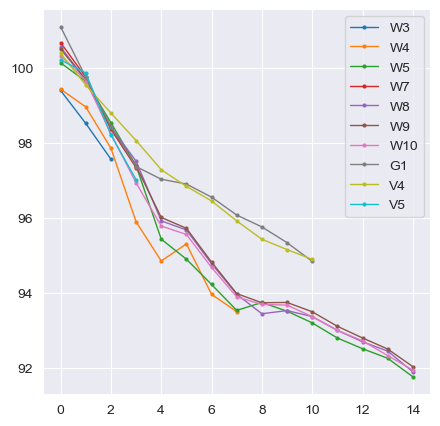

In [5]:
import seaborn as sns
sns.set_style('darkgrid')
df_soh = pd.DataFrame(BATTERY_2_SOH)
df_soh.plot(figsize=(5, 5), marker='o', markersize=2, linewidth=1)

In [6]:
# %matplotlib inline
# # Plot each column of df
# import seaborn as sns

# Count nr of non-nan in soh
BATTERY_2_SOH['W3']

[99.39708407938413,
 98.51890502107103,
 97.56557383419859,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [7]:
BATTERIES = BATTERY_2_SOH.keys()
# BATTERIES = ['G1', 'V4', 'V5', 'W3', 'W4', 'W5', 'W7', 'W8', 'W9', 'W10']
BATTERIES = ['G1', 'V4', 'V5', 'W5', 'W7', 'W8', 'W9', 'W10']

for battery in tqdm(BATTERIES):
    max_cycle = capacity_mat['cap'].shape[0]
    df_bat = pd.DataFrame()
    
    num_cycles = np.count_nonzero(
        ~np.isnan(BATTERY_2_SOH[battery]))

    for cycle in trange(1, num_cycles):

        print(f'battery: {battery}, cycle: {cycle}')
        data_path = f'battery datasets/Stanford/cycle{cycle:02d}/{battery}.mat'
        
        try:
            mat = scipy.io.loadmat(data_path)                    
        except:
            print(f'cycle {cycle} for  battery {battery} does not exist!')
            break
        
        df_cycle = pd.DataFrame()
        for key in mat.keys():
            if key not in ["__header__", "__version__", "__globals__"]:
                df_cycle[key] = mat[key].flatten()
        # Add a column for the battery, where the first entry is battery_soh, and the rest are nan
        batter_soh = BATTERY_2_SOH[battery]

        df_cycle['soh'] = 0
        df_cycle['soh'] = [batter_soh[cycle-1]] + [np.nan] * (df_cycle.shape[0] - 1) 
        df_cycle['cycle'] = cycle
        # concat df cycle to df_bat
        df_bat = pd.concat([df_bat, df_cycle], ignore_index=True)

    # Put batter_soh[cycle] in the last row of the cycle
    df_bat['soh'].iloc[-1] = batter_soh[cycle] 

    df_bat = df_bat.rename(columns={'t_full_vec_M1_NMC25degC': 'time', 'V_full_vec_M1_NMC25degC': 'voltage', 'I_full_vec_M1_NMC25degC': 'current'})
    # save_dest = f'battery datasets/Stanford/interpolated/{battery}.csv'
    # df_bat.to_csv(save_dest)
    # print(f'Interpolated {battery} saved to {save_dest}... ', end='')
    
    df_bat['day'] = (df_bat['time'] // (60*60*2)).astype(int)
    df_bat_day = df_bat[['voltage', 'current', 'time', 'soh', 'day']]
    df_bat_day = df_bat_day[['day', 'voltage', 'current', 'soh']].groupby('day').agg(['mean', 'var', 'skew', 'min', 'max']).reset_index()
    
    # # Reset make the columns to be single level
    df_bat_day.columns = df_bat_day.columns.map('_'.join)
    df_bat_day['soh'] = df_bat_day['soh_mean'].interpolate(method='linear') # linear interpolation on SOH
    df_bat_day = df_bat_day.drop(['soh_var','soh_skew','soh_min','soh_max', 'soh_mean'], axis=1)
    df_bat_day = df_bat_day.rename(columns={'day_': 'day'})
    
    save_dest = f'battery datasets/Stanford/interpolated/{battery}_day.csv'
    df_bat_day.to_csv(save_dest)
    print(f'{battery} split to days saved to {save_dest}')

    del df_bat_day 
    del df_bat

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

battery: W3, cycle: 1
battery: W3, cycle: 2


C:\Users\anton\AppData\Local\Temp\ipykernel_16652\1625543721.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bat['soh'].iloc[-1] = batter_soh[cycle]


W3 split to days saved to battery datasets/Stanford/interpolated/W3_day.csv


  0%|          | 0/7 [00:00<?, ?it/s]

battery: W4, cycle: 1
battery: W4, cycle: 2
battery: W4, cycle: 3
battery: W4, cycle: 4
battery: W4, cycle: 5
battery: W4, cycle: 6
battery: W4, cycle: 7


C:\Users\anton\AppData\Local\Temp\ipykernel_16652\1625543721.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bat['soh'].iloc[-1] = batter_soh[cycle]


W4 split to days saved to battery datasets/Stanford/interpolated/W4_day.csv


  0%|          | 0/14 [00:00<?, ?it/s]

battery: W5, cycle: 1
battery: W5, cycle: 2
battery: W5, cycle: 3
battery: W5, cycle: 4
battery: W5, cycle: 5
battery: W5, cycle: 6
battery: W5, cycle: 7
battery: W5, cycle: 8
battery: W5, cycle: 9
battery: W5, cycle: 10
battery: W5, cycle: 11
battery: W5, cycle: 12
battery: W5, cycle: 13
battery: W5, cycle: 14


C:\Users\anton\AppData\Local\Temp\ipykernel_16652\1625543721.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bat['soh'].iloc[-1] = batter_soh[cycle]


MemoryError: Unable to allocate 12.0 GiB for an array with shape (6, 268389685) and data type float64

,soh,voltage_mean,voltage_var,voltage_skew,voltage_min,voltage_max,current_mean,current_var,current_skew,current_min,current_max,soh
0,0,3.790504,0.047384,-0.212074,0.000000,4.248398,0.011992,3.245444,2.927792,-4.836639,14.541321,98.957995
1,1,3.788092,0.042030,-0.268824,3.271267,4.200413,-0.067167,3.023730,2.946000,-4.830399,14.543121,98.894703
2,2,3.760897,0.046241,-0.058098,3.268387,4.200385,-0.002916,3.413853,2.910185,-4.849411,14.542114,98.831411
3,3,3.793059,0.048804,-0.337663,3.264859,4.200468,0.077854,3.350326,2.981442,-4.837540,14.541901,98.768119
4,4,3.795584,0.046550,-0.301157,3.262941,4.200391,-0.013774,3.065389,2.978492,-4.839340,14.543457,98.704827
5,5,3.779255,0.042843,-0.199015,3.261581,4.200367,-0.069554,2.993347,2.914184,-4.849533,14.541687,98.641535
6,6,3.765676,0.047772,-0.121514,3.258515,4.200469,0.017718,3.362045,2.899576,-4.836594,14.542297,98.578243
7,7,3.791528,0.049562,-0.325619,3.256100,4.200439,0.076142,3.395698,2.941013,-4.836639,14.544403,98.514952
8,8,3.789870,0.045680,-0.280077,3.255133,4.200368,-0.031914,3.062380,2.912223,-4.828171,14.541534,98.451660
9,9,3.768982,0.044511,-0.144190,3.253118,4.200486,-0.076755,2.956113,2.880573,-4.835823,14.542816,98.388368


In [ ]:
df_bat_day['fft_current'] = df_bat_day['fft_current'].astype(object)
df_bat_day.loc[day]['fft_current'] = tuple(abs(yf))

C:\Users\anton\AppData\Local\Temp\ipykernel_18008\3747988639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bat_day.loc[day]['fft_current'] = tuple(abs(yf))


nan

In [ ]:
df_bat_day.drop(['soh_interpolated_var','soh_interpolated_skew','soh_interpolated_min','soh_interpolated_max'], axis=1)

,day_,voltage_mean,voltage_var,voltage_skew,voltage_min,voltage_max,current_mean,current_var,current_skew,current_min,current_max,soh_interpolated_mean,fft_current
0,0,3.792299,0.047149,-0.239644,0.000000,4.248398,-0.007302,3.173570,2.997843,-4.836639,14.534698,98.518905,NaN
1,1,3.782117,0.040406,-0.221293,3.271267,4.200355,-0.084069,2.982453,2.935361,-4.828758,14.543121,98.518905,NaN
2,2,3.757230,0.049610,-0.071606,3.268653,4.200373,0.076022,3.850771,2.857425,-4.849411,14.542114,98.518905,NaN
3,3,3.805483,0.046597,-0.384226,3.266661,4.200468,0.025956,2.929825,3.047618,-4.830505,14.534058,98.518905,NaN
4,4,3.793450,0.045317,-0.304415,3.265804,4.200334,-0.038345,3.098268,2.950493,-4.839340,14.543457,98.518905,NaN
5,5,3.766982,0.041833,-0.067803,3.264848,4.200367,-0.082182,2.959201,2.899899,-4.849533,14.535797,98.518905,NaN
6,6,3.774127,0.051122,-0.238338,3.261901,4.200469,0.116002,3.756808,2.864308,-4.830994,14.542297,98.518905,NaN
7,7,3.795384,0.048113,-0.277808,3.261389,4.200383,0.011432,3.052007,2.974562,-4.836639,14.542084,98.518905,NaN
8,8,3.789553,0.042762,-0.324695,3.260535,4.200368,-0.068568,3.014327,2.891103,-4.826263,14.534149,98.518905,NaN
9,9,3.751782,0.045869,0.019143,3.259437,4.200486,-0.082743,2.934914,2.882841,-4.835823,14.542816,98.518905,NaN


In [ ]:

# For each day, compute the average, variance, kurtoisis, skewness, min, max



# For each day, the fft for current and voltage
# df_bat_day['fft_current'] = np.nan
# for day in tqdm(df_temp['day'].unique()):
#     df_temp = df_bat.query('day == @day')
#     y = df_temp['current'].values
#     yf = np.fft.fft(y)

#     # yf is an array of complex numbers, so we need to convert it to real numbers
#     yf = np.abs(yf)
#     yf = yf[range(int(len(yf)/2))]
#     df_bat_day.loc[day] = yf 



C:\Users\anton\AppData\Local\Temp\ipykernel_18008\2986296726.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm(df_temp['day'].unique()):


  0%|          | 0/1 [00:00<?, ?it/s]

KeyError: 'day'

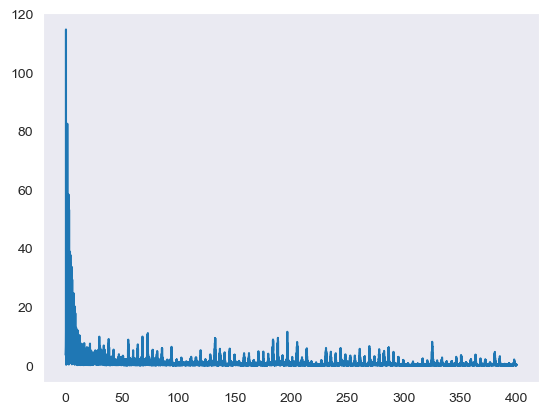

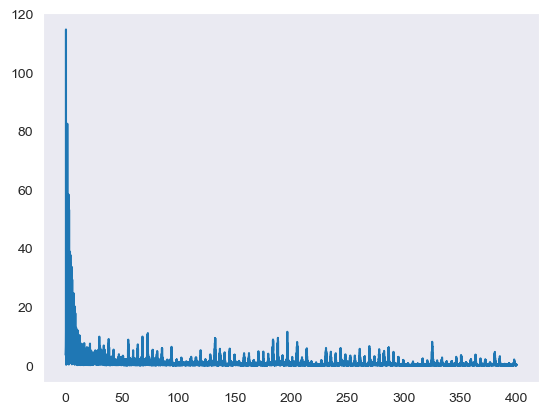

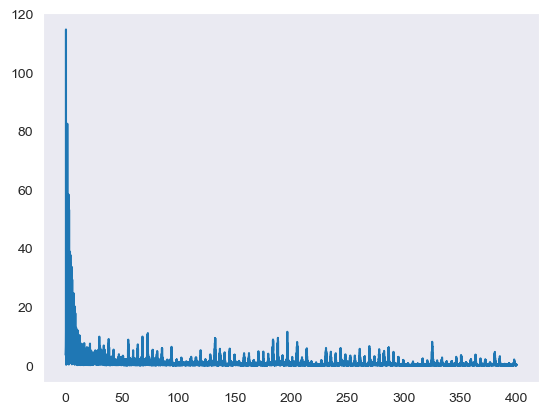

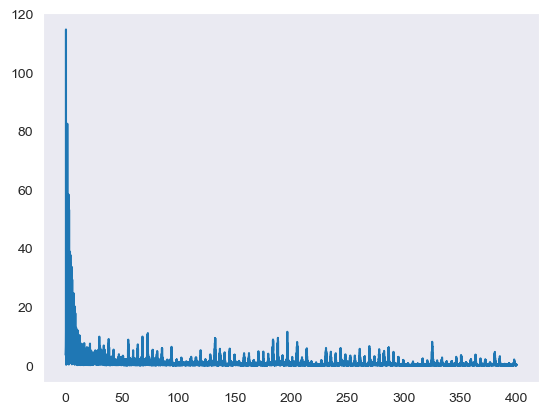

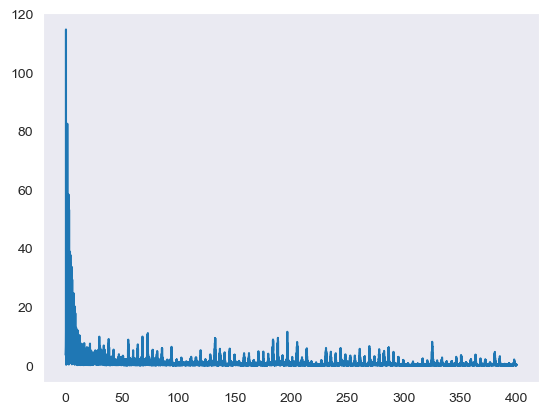

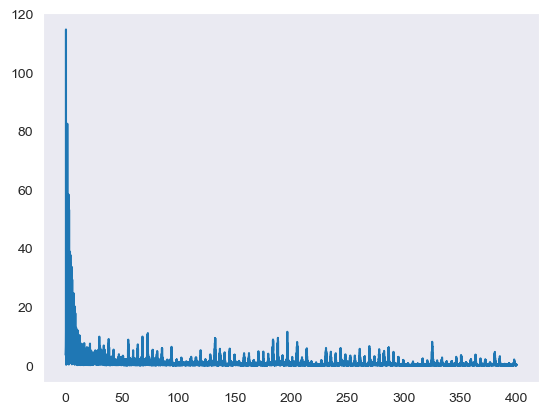

In [ ]:
# Perform fourier transform on the data
from scipy.fft import fft, fftfreq
# Number of sample points
N = 50000
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = df_cycle['I_full_vec_M1_NMC25degC'].values

rows = y.shape[0]
num_windows = 5
window_size = rows // num_windows

for i in range(0, rows, window_size):
    y_temp = y[i:i+100]
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.show()


In [ ]:
from tqdm import tqdm.notebook.tqdm as tqdm

C:\Users\anton\AppData\Local\Temp\ipykernel_21524\4190690187.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(df_cycle)-1)):


  0%|          | 0/6954213 [00:00<?, ?it/s]

C:\Users\anton\AppData\Local\Temp\ipykernel_21524\4190690187.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cycle['Cycle Number'][i+1] = 1
C:\Users\anton\AppData\Local\Temp\ipykernel_21524\4190690187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cycle['Cycle Number'][i+1] = 0


In [ ]:
df_cycle

,I_full_vec_M1_NMC25degC,Step_Index_full_vec_M1_NMC25degC,V_full_vec_M1_NMC25degC,ch_cap_full_vec_M1_NMC25degC,dis_cap_full_vec_M1_NMC25degC,t_full_vec_M1_NMC25degC,Cycle Number
0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0
1,0.000000,1,4.113577,0.000000,0.000000,0.100900,1
2,0.000000,1,4.113518,0.000000,0.000000,0.200500,1
3,0.000000,1,4.113614,0.000000,0.000000,0.301400,1
4,0.000000,1,4.113520,0.000000,0.000000,0.401000,1
...,...,...,...,...,...,...,...
6954209,-1.515411,14,3.292174,0.913945,4.793801,941782.940956,484336
6954210,-1.509132,14,3.292273,0.913945,4.793844,941783.041756,484336
6954211,-1.525429,14,3.292628,0.913945,4.793886,941783.141156,484336
6954212,-1.505707,14,3.292485,0.913945,4.793927,941783.240556,484336


In [ ]:
df_cycle.groupby('day')

array([<Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>,
       <Axes: xlabel='day'>, <Axes: xlabel='day'>, <Axes: xlabel='day'>],
      dtype=object)

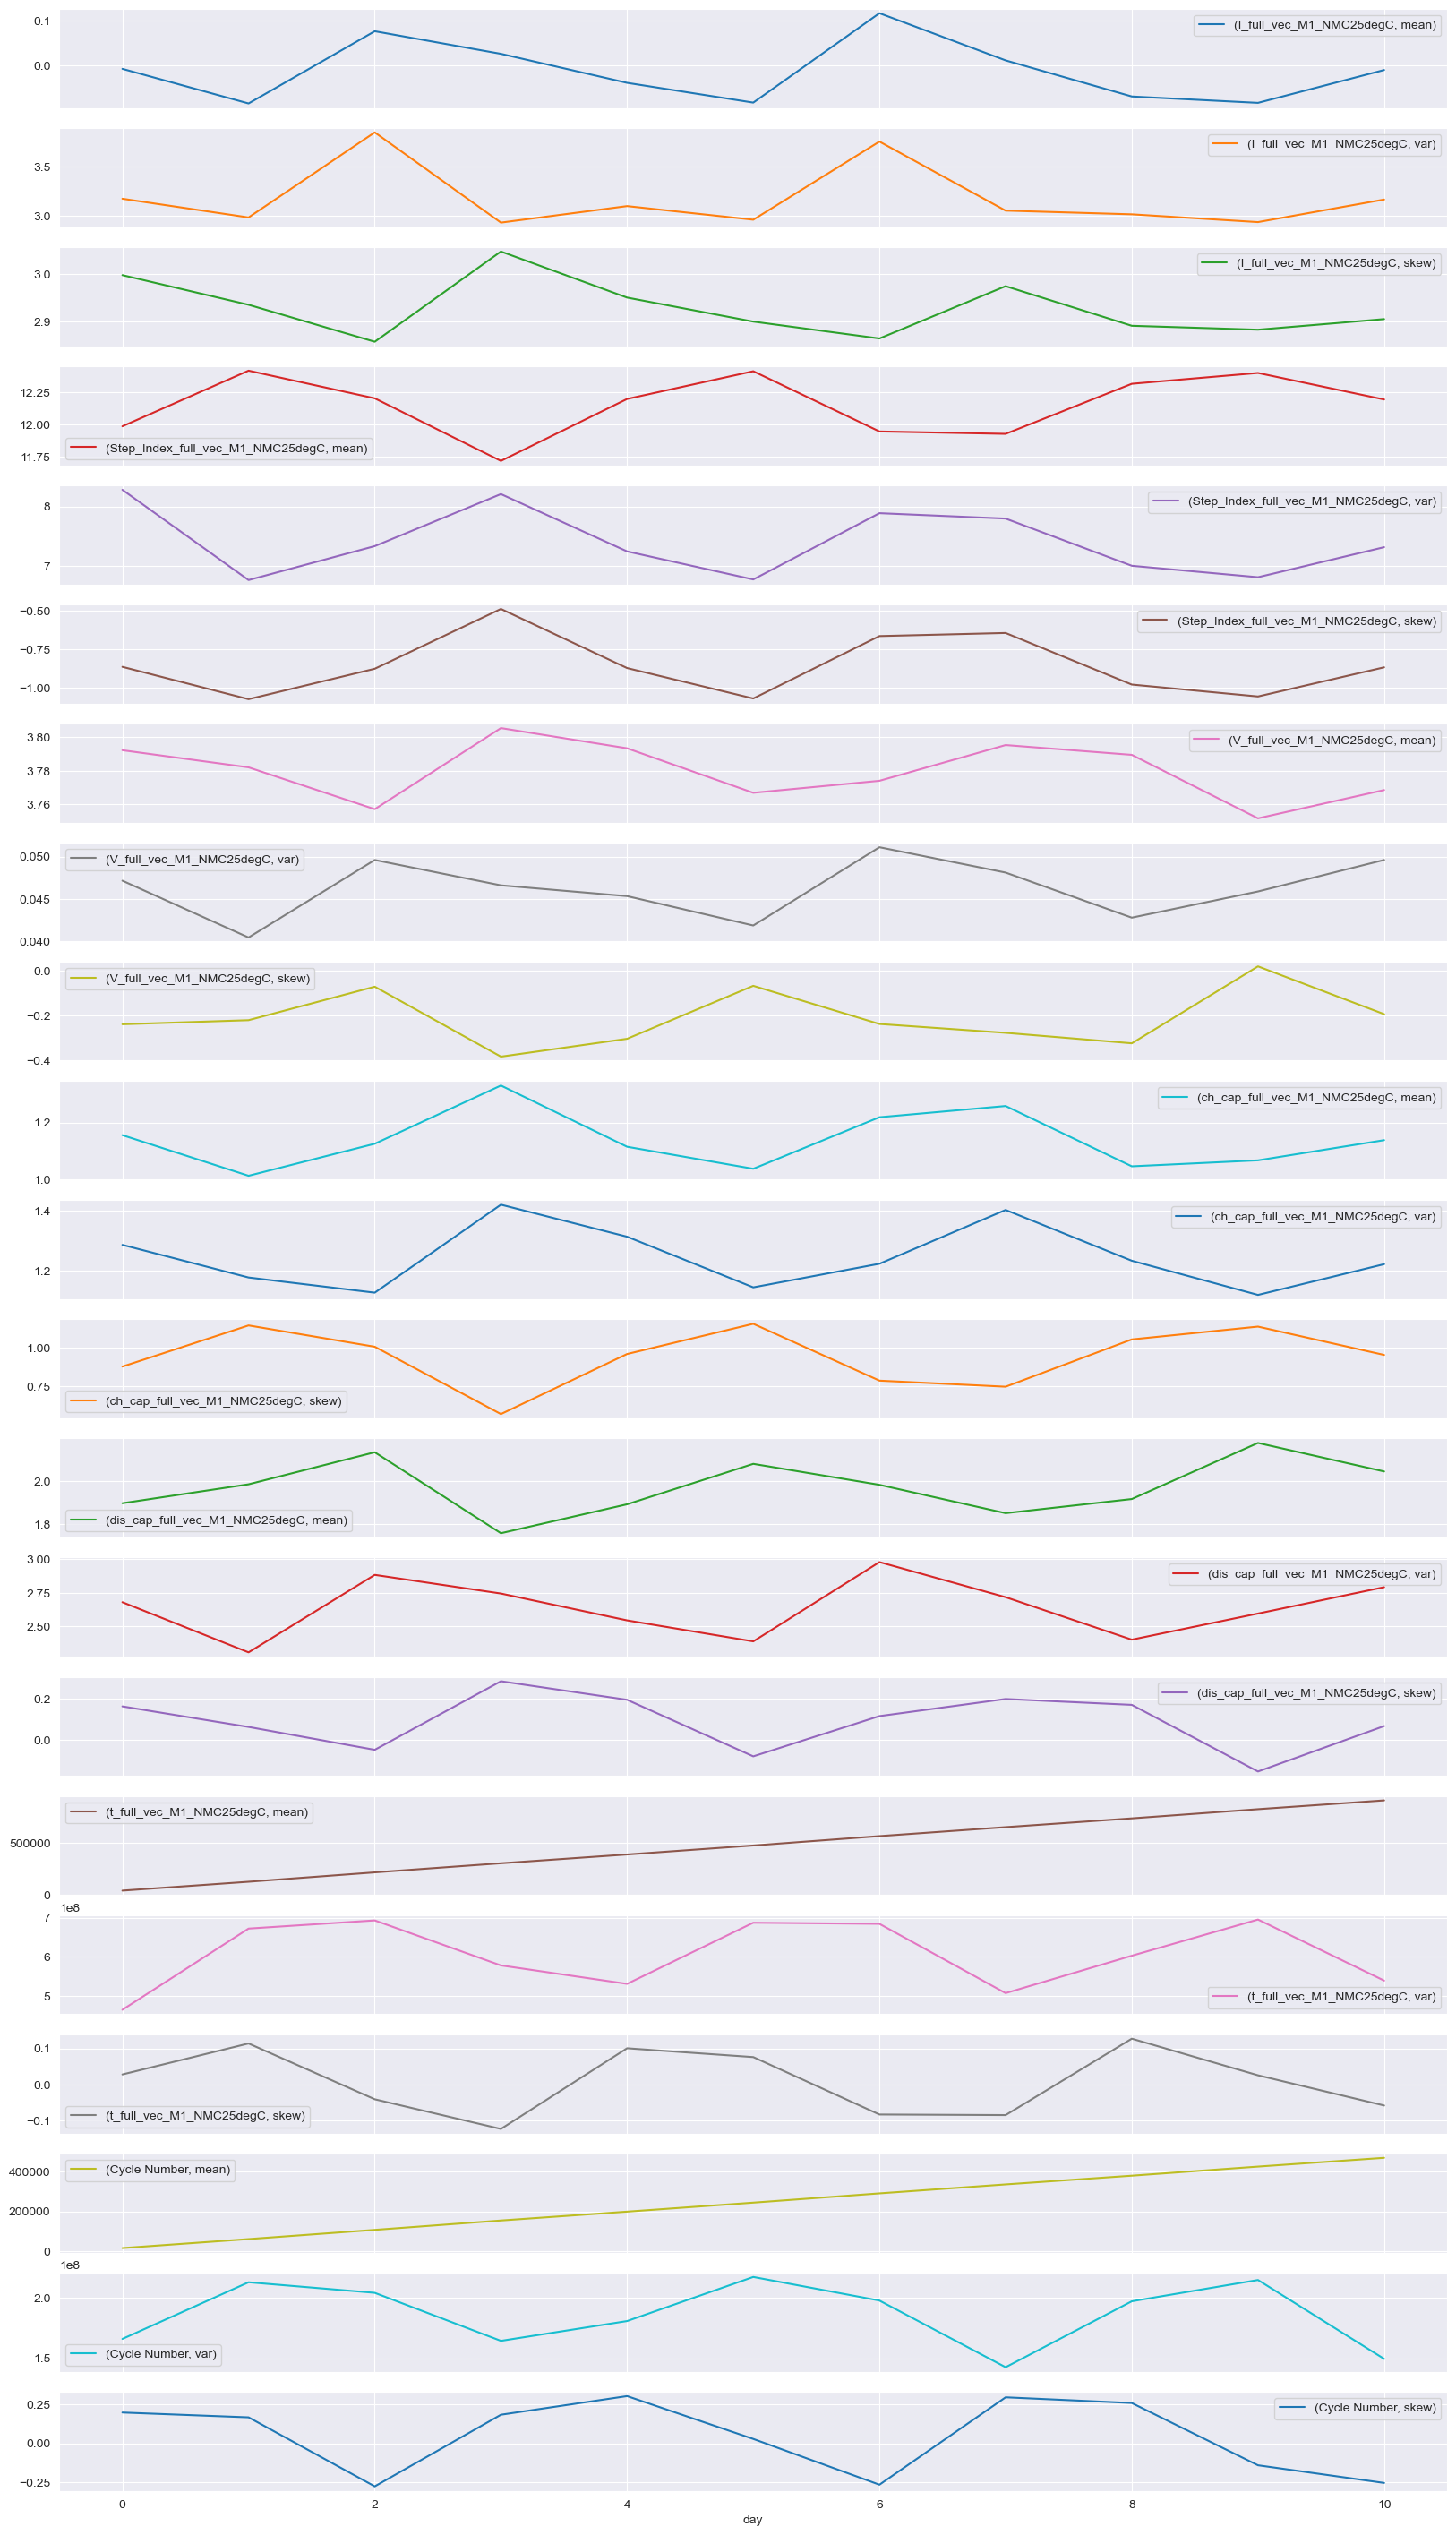

In [ ]:
# Plot df_cycle
# df_cycle.plot(subplots=True, figsize=(20, 12))

# in the dataframe, there is a column t_full_vec_M1_NMC25degC, which is the time in seconds, I want to create a rolling window of 60*60*24 (one day)
# and create a column that indicated what day it is, and then groupby that day and average the data
# then plot the data

# Create a column that indicates the day
df_cycle['day'] = (df_cycle['t_full_vec_M1_NMC25degC'] // (60*60*24)).astype(int)

# Groupby the day and average, variance, kurtosis, skewness, etc.
df_cycle.groupby('day').agg(['mean', 'var', 'skew']).plot(subplots=True, figsize=(20, 12*3))



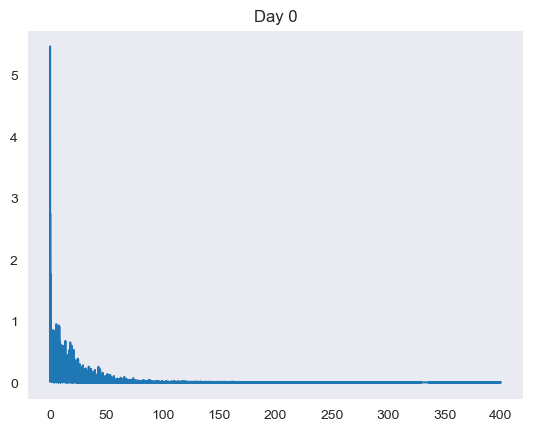

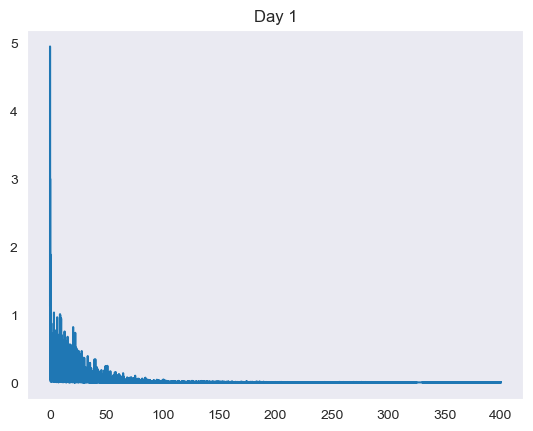

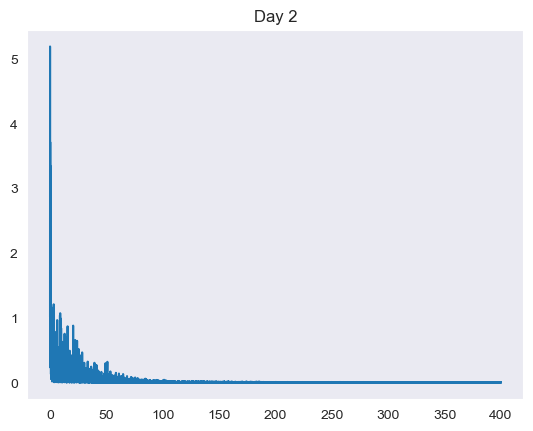

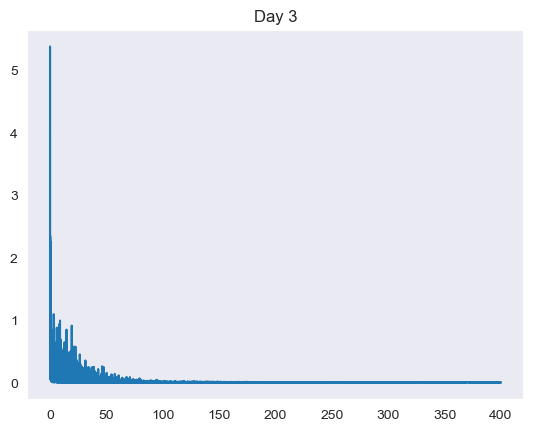

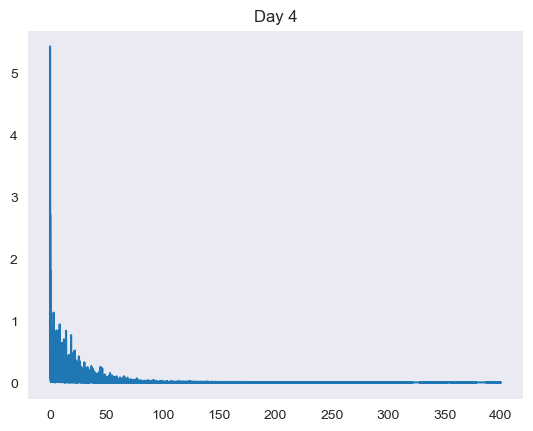

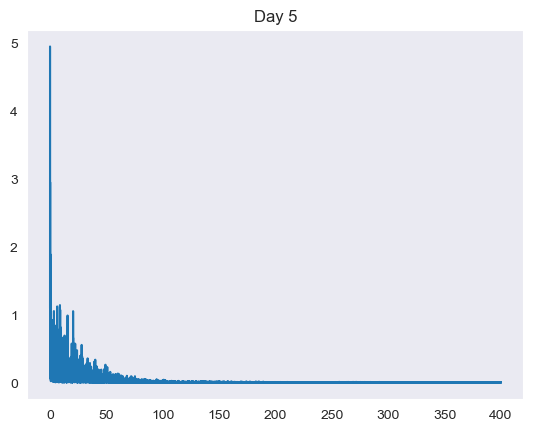

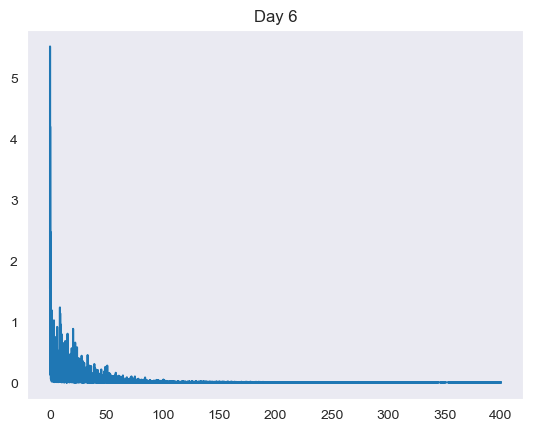

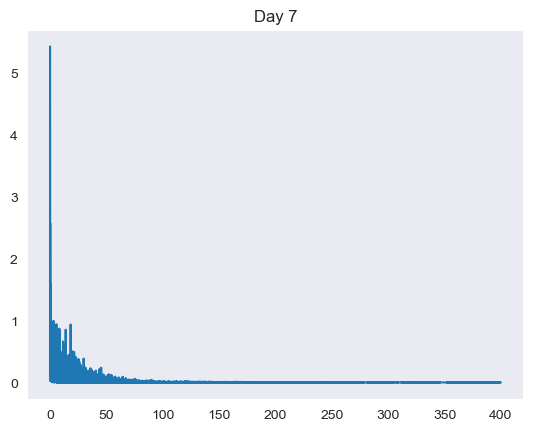

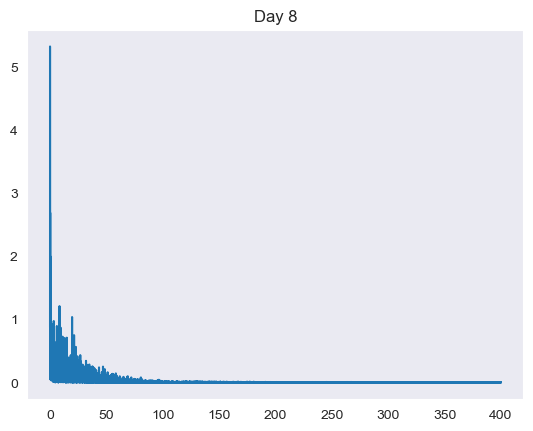

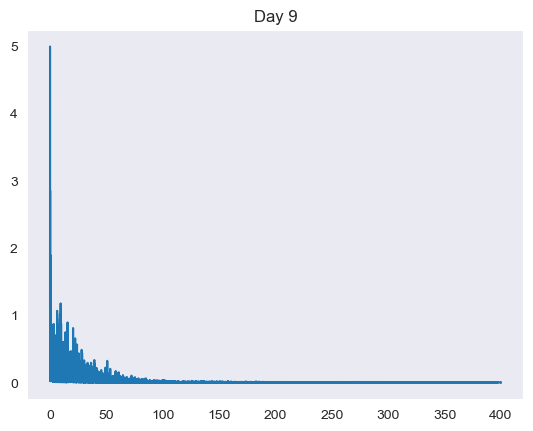

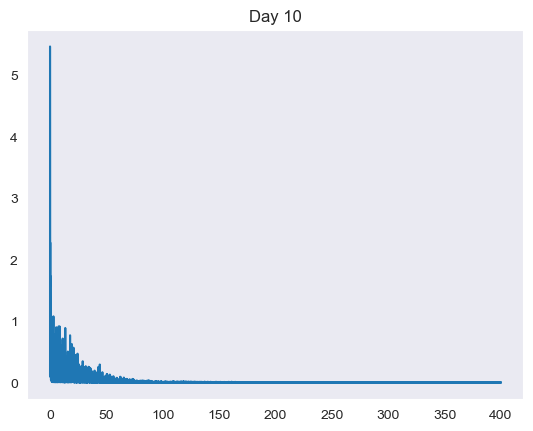

In [ ]:
# Compute the fft for each day
from scipy.fft import fft, fftfreq
# Number of sample points
N = 100000
# sample spacing
T = 1.0 / 800.0

for day in df_cycle['day'].unique():
    df_day = df_cycle[df_cycle['day'] == day]
    y = df_day['I_full_vec_M1_NMC25degC'].values
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.title(f'Day {day}')
    plt.show()